In [2]:
#!/usr/bin/python3
# coding: utf-8
import pandas as pd
import numpy as np
from time import time
import os
import random
import xlrd
import xlwt
import sys
from scipy import optimize
from tqdm import tqdm_notebook
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, mutual_info_classif
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import manifold
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [5]:



########################################################################################################################
# 线性拟合
def f_1(x, a, b):
    return a * x + b

########################################################################################################################
# 除去重复
def remove_duplicate(x):  # the input should be the list style
    x = x.reshape(1, -1)
    x = x[0, :].tolist()
    output = []
    for i in x:
        if i not in output:
            output.append(i)
    return output

########################################################################################################################
# 归一化同种样品的能量
def normalize_single(spectra):
    spectra_max = np.max(spectra, axis=1)
    spectra_max = spectra_max.reshape(-1, 1)
    spectra_mean = np.mean(spectra)
    spectra_output = spectra*spectra_mean/spectra_max
    return spectra_output

########################################################################################################################
# 归一化同种样品的能量
def normalize_single_1(spectra):
    wh = np.where(spectra == np.max(spectra))
    spectra_max = spectra[:, wh[1][0]]
    spectra_max = spectra_max.reshape(-1, 1)
    spectra_mean = np.mean(spectra_max)
    spectra_output = spectra * spectra_mean / spectra_max
    return spectra_output

########################################################################################################################
# 归一化同种样品的能量
def normalize_single_2(spectra):
    spectra_mean_single = np.mean(spectra, axis=1)
    spectra_mean_single = spectra_mean_single.reshape(-1, 1)
    spectra_mean = np.mean(spectra)
    spectra_output = spectra * spectra_mean / spectra_mean_single
    return spectra_output

########################################################################################################################
# 归一化样品的能量
def normalize(spectra, group_set):
    X_output = np.zeros((spectra.shape[0], spectra.shape[1]))
    temp = remove_duplicate(group_set)
    group_set = group_set[:, 0].tolist()
    for indexj in range(len(temp)):
        temp_order = [i for i, x in enumerate(group_set) if x == temp[indexj]]
        X_temp = spectra[temp_order, :]
        X_temp = normalize_single_1(X_temp)
        X_output[temp_order] = X_temp
    return X_output

########################################################################################################################
# 归一化样品的能量
def normalize1(spectra):
    spectra_mean_single = np.mean(spectra, axis=1)
    spectra_mean_single = spectra_mean_single.reshape(-1, 1)
    spectra_mean = np.mean(spectra)
    X_output = spectra * spectra_mean / spectra_mean_single
    return X_output

########################################################################################################################
# 相对标准差
def relative_standard_derivation(x_predict, x_te):  # the imput should be the list style
    output = np.std((x_predict - x_te) / x_te) #* np.sqrt(len(x_te) / (len(x_te) - 1))
    return output

########################################################################################################################
# 相对偏差
def relative_error(x_predict, x_true):  # the imput should be the list style
    output = np.mean(abs(x_predict - x_true) / x_true)
    return output

########################################################################################################################
# limited of detection
def limited_of_detection(slope, rsd_calibration):
    output = 3 * np.mean(rsd_calibration) / slope
    return output

def relu(x):
    return np.maximum(x, 0.0)

def relu_deriv(x):
    x[x > 0] = 1.0
    x[x <= 0] = 0.0
    return x

def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1.0 - np.tanh(x)*np.tanh(x)

def logistic(x):
    return 1/(1+np.exp(-x))

def logistic_derivative(x):
    return logistic(x)*(1-logistic(x))

def prelu(x):
    return np.maximum(x, 0.0) + 0.25*np.minimum(x, 0.0)

def prelu_deriv(x):
    x[x > 0] = 1.0
    x[x < 0] = 0.25
    return x

class BPNNet:

    def __init__(self, layers, activation=["tanh", "tanh"], batch_size="None"):
        self.layers = layers
        # active function
        self.activation = activation
        if self.activation[0] == 'logistic':
            self.activation0 = logistic
            self.activation0_deriv = logistic_derivative
        elif self.activation[0] == 'tanh':
            self.activation0 = tanh
            self.activation0_deriv = tanh_deriv
        elif self.activation[0] == 'relu':
            self.activation0 = relu
            self.activation0_deriv = relu_deriv
        elif self.activation[0] == 'prelu':
            self.activation0 = prelu
            self.activation0_deriv = prelu_deriv
        if self.activation[1] == 'logistic':
            self.activation1 = logistic
            self.activation1_deriv = logistic_derivative
        elif self.activation[1] == 'tanh':
            self.activation1 = tanh
            self.activation1_deriv = tanh_deriv
        elif self.activation[1] == 'relu':
            self.activation1 = relu
            self.activation1_deriv = relu_deriv
        elif self.activation[1] == 'prelu':
            self.activation1 = prelu
            self.activation1_deriv = prelu_deriv
        # batch_size
        if batch_size == "None":
            self.batch_size = 0
        else:
            self.batch_size = batch_size
        # random weights & weights updates
        self.weights = []
        self.weights.append((2*np.random.random((layers[0]+1,layers[1]))-1)*0.25)
        for i in range(2,len(self.layers)):
            self.weights.append((2*np.random.random((layers[i - 1],layers[i])) - 1) * 0.25)
        # random weights & weights updates
        self.updates = []
        self.updates.append(np.zeros((self.layers[0] + 1, self.layers[1])))
        for i in range(2,len(self.layers)):
            self.updates.append(np.zeros((self.layers[i - 1], self.layers[i])))
    def fit(self, X, y, learning_rate_max=0.3, learning_rate_min=0.1, epochs=2000000, error_threshold=1e-8):  # learning_rate=0.2
        # self.weights 的数据更新
        self.weights[0] = (2*np.random.random((self.layers[0]+1, self.layers[1]))-1)*0.25
        for i in range(2, len(self.layers)):
            self.weights[i - 1] = (2*np.random.random((self.layers[i - 1],self.layers[i])) - 1) * 0.25
        #print(self.weights)
        # atlest_2d函数:确认X至少二位的矩阵
        X = np.atleast_2d(X)
        # 初始化矩阵全是1（行数，列数+1是为了有B这个偏向）
        temp = np.ones([X.shape[0], X.shape[1]+1])
        # 行全选，第一列到倒数第二列
        temp[:,0:-1]=X
        X = temp
        # 真实值的y数组
        y = np.array(y)
        # batch_size 的mini_batch计算
        batch_size = int(self.batch_size * X.shape[0])+1
        print('batch_size = '+str(batch_size))
        # epoch 每一次循环的BP
        for k in range(epochs):
            learning_rate = learning_rate_max - (learning_rate_max-learning_rate_min) * k/epochs
            # mini_batch 随机取出规定数目的序号list
            order = random.sample(range(X.shape[0]), batch_size)
            #print(order)
            # self.updates 的数据更新
            self.updates[0] = np.zeros((self.layers[0] + 1, self.layers[1]))
            for i in range(2, len(self.layers)):
                self.updates[i-1] = np.zeros((self.layers[i - 1], self.layers[i]))
            # print(self.updates)
            # mini_batch 梯度下降抽样
            error = 0
            error_cache = 1
            for j in range(batch_size):
                temp_j = order[j]
                # 根据order产生的随机数数列，循环每次一个样本
                a = [X[temp_j]]
                a.append(self.activation0(np.dot(a[0], self.weights[0])))
                a.append(self.activation1(np.dot(a[1], self.weights[1])))
                # 向前传播，得到每个节点的输出结果
                error_temp = y[temp_j] - a[-1]
                error += error_temp
            error = error/batch_size   # 最后一层错误率
            deltas = [error * self.activation1_deriv(a[-1])]
            deltas.append(deltas[-1].dot(self.weights[1].T) * self.activation0_deriv(a[1]))
            deltas.reverse()
            if abs(error) <= error_threshold:
                print('k = '+str(k))
                print('error = '+str(error))
                break
            elif k==epochs_whole-1:
                self.weights = weights_cache
                print('iteration steps out of band')
                print('error = '+str(error_cache))
            for i in range(len(self.weights)):
                layer = np.atleast_2d(a[i])
                delta = np.atleast_2d(deltas[i])
                self.updates[i] += learning_rate * layer.T.dot(delta)
            for i in range(len(self.updates)):
                self.weights[i] += self.updates[i]/batch_size
            if error < error_cache:
                error_cache = error
                weights_cache = self.weights
    def predict(self, x):
        # x=np.array(x)
        r1, c1 = x.shape
        aa = np.ones(shape=[r1, 1])
        for indexi in range(r1):
            temp = np.ones(c1 + 1)
            temp[0:-1] = x[indexi].T
            a = temp
            a = self.activation0(np.dot(a, self.weights[0]))
            a = self.activation1(np.dot(a, self.weights[1]))
            aa[indexi] = a
        return (aa)
    def load_weights(self, path_load):
        '''''
        worksheet = xlrd.open_workbook(path_load)
        sheet_names = worksheet.sheet_names()
        '''''
        for indexi in range(len(self.weights)):
            data = pd.read_excel(path_load, sheet_name=str(indexi),
                                 header=0, skiprows=0)
            self.weights[indexi] = np.array(data)

    def save_weights(self, path_save):
        '''''
        workbook = xlwt.Workbook(encoding='ascii')

        for indexi in range(len(self.weights)):
            cmp = self.weights[indexi]
            worksheet = workbook.add_sheet(str(indexi))
            for i in range(len(cmp)):
                for j, k in enumerate(cmp[i]):
                    worksheet.write(i, j, k)
        workbook.save(path_save)
        '''''
        with pd.ExcelWriter(path_save) as writer:
            for indexi in range(len(self.weights)):
                print('indexi = '+str(indexi))
                data = self.weights[indexi]
                data = pd.DataFrame(data)
                data.to_excel(writer, sheet_name=str(indexi), index=False, header=False)
'''
    def rigidity_normalization(y, range0=range(300,320), range1=range(400,420)):
        peek0 = np.max(y[range0])
        peek1 = np.max(y[range1])
        rigidity = peek0 / peek1
        y = y / rigidity
        return y
'''
#  BPNNet
########################################################################################################################
#本部分可调
learning_rate_max_whole = 0.30
learning_rate_min_whole = 0.10
epochs_whole = 2000000
batch_size_whole = 0
threshold = 5e-8
########################################################################################################################
# active function

########################################################################################################################
date = '20191212'
choose_element = 'CaO' #SiO2	Fe2O3	Al2O3	CaO	MgO	K2O	Na2O	TiO2
for choose_element in tqdm_notebook(['SiO2','Fe2O3','Al2O3','CaO','MgO','K2O','Na2O','TiO2']):
    for process in tqdm_notebook(['DenoisedSpectrum', 'SmoothedSpectrum']):
        try_num = 1
        #process = 'SmoothedSpectrum' #DenoisedSpectrum SmoothedSpectrum
        data_file_path = os.path.join(r'D:\data\china_2020\coeffs_cut', choose_element)
        menu_guide_path = r'D:\data\Menu_Guide-quantitative.xlsx'
        save_path_file = os.path.join(r'D:\data\china_2020\result\BPNN results', date, choose_element+'_'+str(try_num))
        if not os.path.exists(save_path_file):
            os.mkdir(save_path_file)
        save_path_file = os.path.join(save_path_file, process)
        if not os.path.exists(save_path_file):
            os.mkdir(save_path_file)
        #process_path = ['DenoisedSpectrum', 'SmoothedSpectrum']
        choose_type = 'Soil_Type'
        file_list = 'Spectra_Name'
        sample_list = 'Spectra_Name'
        data_flag = pd.read_excel(menu_guide_path)
        file_names = np.array(data_flag[file_list])
        concentration = np.array(data_flag[choose_element])
        sample_type = np.array(data_flag[choose_type])
        sample_name_unique = np.array(data_flag[sample_list])
        train_test_set = np.array(data_flag['Train']).tolist()
        type_list = data_flag[choose_type].drop_duplicates(keep='first').tolist()
        p = 150  #p可调
        ########################################################################################################################
        # train list
        #train_position = [i for i, j in enumerate(train_test_set) if j == 1]
        train_position = [1, 3, 12, 13, 21]
        # test list
        #test_position = [i for i, j in enumerate(train_test_set) if j == 0]
        test_position = [1, 3, 12, 13, 21]
        ########################################################################################################################
        # Input Data

        state = 'pellet'
        X_tr = None
        for index_i in train_position:
            temp_sample_type = type_list.index(sample_type[index_i])
            temp_sample_name = sample_name_unique[index_i]
            temp_concentration = concentration[index_i]
            for j in range(8):
                file = state+'_'+file_names[index_i]+'_'+process+'_'+str(j)+'.txt'
                read_path = os.path.join(data_file_path, file)
                if not os.path.exists(read_path):
                    print(read_path)
                    continue
                data_cache = np.loadtxt(read_path)
                data_cache = data_cache.flatten()
                if X_tr is None:
                    X_tr = data_cache
                    y_tr = temp_concentration
                    type_tr = temp_sample_type
                    group_tr = index_i
                    sample_name_tr = temp_sample_name
                    intensity = data_cache
                else:
                    X_tr = np.row_stack((X_tr, data_cache))
                    y_tr = np.row_stack((y_tr, temp_concentration))
                    type_tr = np.row_stack((type_tr, temp_sample_type))
                    sample_name_tr = np.row_stack((sample_name_tr, temp_sample_name))
                    group_tr = np.row_stack((group_tr, index_i))
        print('X_tr.shape = '+str(X_tr.shape))
        print('y_tr.shape = '+str(y_tr.shape))

        state = 'rock'
        X_te = None
        for index_i in train_position:
            temp_sample_type = type_list.index(sample_type[index_i])
            temp_sample_name = sample_name_unique[index_i]
            temp_concentration = concentration[index_i]
            for j in range(8):
                file = state+'_'+file_names[index_i]+'_'+process+'_'+str(j)+'.txt'
                read_path = os.path.join(data_file_path, file)
                if not os.path.exists(read_path):
                    print(read_path)
                    continue
                data_cache = np.loadtxt(read_path)
                data_cache = data_cache.flatten()
                if X_te is None:
                    X_te = data_cache
                    y_te = temp_concentration
                    type_te = temp_sample_type
                    group_te = index_i
                    sample_name_te = temp_sample_name
                else:
                    X_te = np.row_stack((X_te, data_cache))
                    y_te = np.row_stack((y_te, temp_concentration))
                    type_te = np.row_stack((type_te, temp_sample_type))
                    sample_name_te = np.row_stack((sample_name_te, temp_sample_name))
                    group_te = np.row_stack((group_te, index_i))
        print('X_te.shape = '+str(X_te.shape))
        print('y_te.shape = '+str(y_te.shape))


        '''
        for index_i in train_position:
            temp_sample_type = type_list.index(sample_type[index_i])
            temp_sample_name = sample_name_unique[index_i]
            temp_concentration = concentration[index_i]
            for i in range(3):
                for j in range(8):
                    file = state+'_'+file_names[index_i]+'_'+process+'_'+str(i+1)+'_'+str(j)+'.txt'
                    read_path = os.path.join(data_file_path, file)
                    if not os.path.exists(read_path):
                        print(read_path)
                        continue
                    data_cache = np.loadtxt(read_path)
                    data_cache = data_cache.flatten()
                    if X_tr is None:
                        X_tr = data_cache
                        y_tr = temp_concentration
                        type_tr = temp_sample_type
                        group_tr = index_i
                        sample_name_tr = temp_sample_name
                        intensity = data_cache
                    else:
                        X_tr = np.row_stack((X_tr, data_cache))
                        y_tr = np.row_stack((y_tr, temp_concentration))
                        type_tr = np.row_stack((type_tr, temp_sample_type))
                        sample_name_tr = np.row_stack((sample_name_tr, temp_sample_name))
                        group_tr = np.row_stack((group_tr, index_i))
        print('X_tr.shape = '+str(X_tr.shape))
        print('y_tr.shape = '+str(y_tr.shape))

        state = 'rock'
        X_te = None
        for index_i in train_position:
            temp_sample_type = type_list.index(sample_type[index_i])
            temp_sample_name = sample_name_unique[index_i]
            temp_concentration = concentration[index_i]
            for i in range(3):
                for j in range(8):
                    file = state+'_'+file_names[index_i]+'_'+process+'_'+str(i+1)+'_'+str(j)+'.txt'
                    read_path = os.path.join(data_file_path, file)
                    if not os.path.exists(read_path):
                        print(read_path)
                        continue
                    data_cache = np.loadtxt(read_path)
                    data_cache = data_cache.flatten()
                    if X_te is None:
                        X_te = data_cache
                        y_te = temp_concentration
                        type_te = temp_sample_type
                        group_te = index_i
                        sample_name_te = temp_sample_name
                    else:
                        X_te = np.row_stack((X_te, data_cache))
                        y_te = np.row_stack((y_te, temp_concentration))
                        type_te = np.row_stack((type_te, temp_sample_type))
                        sample_name_te = np.row_stack((sample_name_te, temp_sample_name))
                        group_te = np.row_stack((group_te, index_i))
        print('X_te.shape = '+str(X_te.shape))
        print('y_te.shape = '+str(y_te.shape))
        '''

        ########################################################################################################################
        # Te & Tr true concentration
        group_tr_remove_duplicate = remove_duplicate(group_tr)
        group_te_remove_duplicate = remove_duplicate(group_te)
        group_tr_temp = group_tr.reshape(1, -1)
        group_tr_temp = group_tr_temp[0, :].tolist()
        group_te_temp = group_te.reshape(1, -1)
        group_te_temp = group_te_temp[0, :].tolist()
        order_y_tr = [group_tr_temp.index(x) for x in group_tr_remove_duplicate]
        order_y_te = [group_te_temp.index(x) for x in group_te_remove_duplicate]
        y_tr_true = y_tr[order_y_tr,:]
        y_te_true = y_te[order_y_te,:]
        ########################################################################################################################
        # standard数据归一化
        '''
        min_max_scaler1 = preprocessing.MinMaxScaler()
        X_tr = min_max_scaler1.fit_transform(X_tr)
        X_te = min_max_scaler1.transform(X_te)
        min_max_scaler2 = preprocessing.MinMaxScaler()
        y_tr = min_max_scaler2.fit_transform(y_tr)
        y_te = min_max_scaler2.transform(y_te)
        min_max_scaler3 = preprocessing.MinMaxScaler()
        group_tr_add = min_max_scaler3.fit_transform(group_tr)
        group_te_add = min_max_scaler3.transform(group_te)
        '''
        ########################################################################################################################
        # standard数据归一化for different states
        min_max_scaler1 = preprocessing.MinMaxScaler()
        X_tr = min_max_scaler1.fit_transform(X_tr)
        min_max_scaler1_te = preprocessing.MinMaxScaler()
        X_te = min_max_scaler1_te.fit_transform(X_te)
        min_max_scaler2 = preprocessing.MinMaxScaler()
        y_tr = min_max_scaler2.fit_transform(y_tr)
        min_max_scaler2_te = preprocessing.MinMaxScaler()
        y_te = min_max_scaler2_te.fit_transform(y_te)
        min_max_scaler3 = preprocessing.MinMaxScaler()
        group_tr_add = min_max_scaler3.fit_transform(group_tr)
        min_max_scaler3_te = preprocessing.MinMaxScaler()
        group_te_add = min_max_scaler3_te.fit_transform(group_te)
        ########################################################################################################################



        r0, c0 = X_tr.shape
        print('r0,c0 = '+str(r0)+', '+str(c0))
        ########################################################################################################################

        k = 6
        rr = 10

        predict_train_temp = np.empty(shape=[len(y_tr_true), k * rr])
        predict_train_temp_rsd = np.empty(shape=[len(y_tr_true), k * rr])
        predict_val_temp = np.empty(shape=[len(y_tr_true), k * rr])
        predict_val_temp_rsd = np.empty(shape=[len(y_tr_true), k * rr])
        predict_tes_temp = np.empty(shape=[len(y_te), k * rr])

        nn = BPNNet([c0, 5, 1], ['tanh','tanh'], batch_size_whole)   #神经元个数5-8
        '''''
        REtes = 0.4
        R2 = 0.97
        loop1 = 1oop2 = 1
        while REtes>0.30  or R2<0.998:
            print("loop1:")
            print(loop1)
        '''''
        rskf = RepeatedStratifiedKFold(n_splits=k, n_repeats=rr)
        combine = list(rskf.split(X_tr, group_tr))
        indexi = 0
        t0 = time()


        for train_index, val_index in combine:
            X_train = X_tr[train_index]
            y_train = y_tr[train_index]
            group_train = group_tr[train_index]
            X_val = X_tr[val_index]
            y_val = y_tr[val_index]
            group_val = group_tr[val_index]
            nn.fit(X_train, y_train, learning_rate_max=learning_rate_max_whole, learning_rate_min=learning_rate_min_whole, epochs=epochs_whole, error_threshold=threshold)
            nn.save_weights(save_path_file + r'\weights' + str(indexi) + '.xlsx')

            temp = nn.predict(X_train)
            #  inverse transform standard
            temp = min_max_scaler2.inverse_transform(temp)
            temp1 = remove_duplicate(group_train)
            group_train = group_train[:, 0].tolist()
            for indexj in range(len(temp1)):
                temp_order = [i for i, x in enumerate(group_train) if x == temp1[indexj]]
                predict_train_temp[indexj, indexi] = np.mean(temp[temp_order])
                predict_train_temp_rsd[indexj, indexi] = np.std(temp[temp_order])
                #* np.sqrt(len(temp_order) / (len(temp_order) - 1))

            temp = nn.predict(X_val)
            #  inverse transform standard
            temp = min_max_scaler2.inverse_transform(temp)
            temp1 = remove_duplicate(group_val)
            group_val = group_val[:, 0].tolist()
            for indexj in range(len(temp1)):
                temp_order = [i for i, x in enumerate(group_val) if x == temp1[indexj]]
                predict_val_temp[indexj, indexi] = np.mean(temp[temp_order])
                predict_val_temp_rsd[indexj, indexi] = np.std(temp[temp_order])
                                                       #* np.sqrt(len(temp_order) / (len(temp_order) - 1))

            temp = nn.predict(X_te)
            #  inverse transform standard
            temp = min_max_scaler2.inverse_transform(temp)
            predict_tes_temp[:, indexi] = temp[:, 0]

            indexi += 1
        print("done in %0.3fs" % (time() - t0))
        # 作图使用的calibration val && validation set的predicted value & errorbar
        #  predicted value
        predict_train = np.mean(predict_train_temp, axis=1)
        predict_train_rsd = np.mean(predict_train_temp_rsd, axis=1)
        predict_val = np.mean(predict_val_temp, axis=1)  # 作图用的calibration线
        predict_val_rsd = np.mean(predict_val_temp_rsd, axis=1)  # 作图用的calibration线的errorbar
        # test data set
        predict_tes = np.mean(predict_tes_temp, axis=1)
        temp1 = remove_duplicate(group_te)
        predict_te = np.empty(shape=[len(temp1), 1])  # 作图用的validation线
        predict_te_rsd = np.empty(shape=[len(temp1), 1])  # 作图用的validation线的errorbar
        group_te = group_te[:, 0].tolist()
        for indexj in range(len(temp1)):
            temp_order = [i for i, x in enumerate(group_te) if x == temp1[indexj]]
            predict_te[indexj, 0] = np.mean(predict_tes[temp_order])
            predict_te_rsd[indexj, 0] = np.std(predict_tes[temp_order]) #* np.sqrt(len(temp_order) / (len(temp_order) - 1))
        # 文章计算Slope 截距
        print('predict_val = '+str(predict_val))
        Slope, intercept = optimize.curve_fit(f_1, y_tr_true[:, 0], predict_val)[0]
        # 文章简图
        nn0 = 10
        start = np.min(y_tr_true) - (np.max(y_tr_true) - np.min(y_tr_true)) / 20.0
        stop = np.max(y_tr_true) + (np.max(y_tr_true) - np.min(y_tr_true)) / 20.0
        x1 = np.linspace(start, stop, num=nn0, endpoint=True)
        y1 = Slope * x1 + intercept  ##  拟合曲线
        plt.plot(x1, y1, color='r', linestyle='--', linewidth=1)
        plt.errorbar(y_tr_true, predict_val, yerr=predict_val_rsd, fmt='o', marker='o', mfc='white', mec='black', ms=5, mew=1,
                     ecolor='black', elinewidth=1, capsize=2)
        plt.errorbar(y_te_true, predict_te[:, 0], yerr=predict_te_rsd[:, 0], fmt='x', marker='x', mfc='white', mec='black',
                     ms=5, mew=1, ecolor='black', elinewidth=1, capsize=2)
        plt.legend(['r2', 'val', 'tes'],
                   loc='upper left',
                   numpoints=1,
                   fancybox=True)
        plt.xlabel('Certified Concentration')
        plt.ylabel('Predicted Concentration')
        plt.show()
        # 文章计算REC RET （使用y_tr_true）REP（使用y_te_true）
        REC = relative_error(predict_train, y_tr_true)
        RET = relative_error(predict_val, y_tr_true)
        REP = relative_error(predict_te, y_te_true)
        # 文章计算RSD(使用 predict_tes && y_te)
        RSD = relative_standard_derivation(predict_tes, y_te)
        # 文章计算LOD
        LOD = limited_of_detection(Slope, predict_val_rsd)
        # 文章计算R2（calibration曲线的r2）
        R2 = r2_score(predict_val, y_tr_true)
        ########################################################################################################################
        # print the results
        title = ["REC", "RET", "REP", "RSD", "LOD", "R2"]
        value = [REC, RET, REP, RSD, LOD, R2]
        print('title = '+str(title))
        print('value = '+str(value))
        ########################################################################################################################
        # save the results
        # Sheet 1
        # REC, RET, REP, RSD, LOD, R2 value
        cmp = [title, value]
        workbook = xlwt.Workbook(encoding='ascii')
        worksheet = workbook.add_sheet('Result')
        for i in range(len(cmp)):
            for j, k in enumerate(cmp[i]):
                worksheet.write(i, j, k)
        # Sheet 2
        worksheet = workbook.add_sheet('Scatter')
        # calibration scatters value
        cal_true = ['cal_true']
        cal_predict = ['cal_predict']
        cal_stander_derivation = ['cal_stander_derivation']
        cal_true += y_tr_true[:,0].tolist()
        print('cal_true = '+str(cal_true))
        cal_predict += predict_val.tolist()
        cal_stander_derivation += predict_val_rsd.tolist()
        cmp0 = [cal_true, cal_predict, cal_stander_derivation]
        print('cmp0 = '+str(cmp0))
        for i in range(len(cmp0)):
            for j, k in enumerate(cmp0[i]):
                worksheet.write(j, i, k)
        # validation scatters value
        val_true = ['val_true']
        val_predict = ['val_predict']
        val_stander_derivation = ['val_stander_derivation']
        val_true += y_te_true[:, 0].tolist()
        val_predict += predict_te[:, 0].tolist()
        val_stander_derivation += predict_te_rsd[:, 0].tolist()
        cmp = [val_true, val_predict, val_stander_derivation]
        print('cmp0 = '+str(cmp0))
        for i in range(len(cmp)):
            for j, k in enumerate(cmp[i]):
                worksheet.write(j, i+len(cmp0), k)
        # Sheet 3
        worksheet = workbook.add_sheet('fitting')
        # fitting line value
        fitting_x = ["fitting_x"]
        fitting_y = ["fitting_y"]
        fitting_x += x1.tolist()
        fitting_y += y1.tolist()
        cmp = [fitting_x, fitting_y]
        for i in range(len(cmp)):
            for j, k in enumerate(cmp[i]):
                worksheet.write(j, i, k)
        workbook.save(os.path.join(save_path_file, r'result.xlsx'))



D:\data\china_2020\coeffs_cut\SiO2\pellet_S2_DenoisedSpectrum_0.txt
D:\data\china_2020\coeffs_cut\SiO2\pellet_S2_DenoisedSpectrum_1.txt
D:\data\china_2020\coeffs_cut\SiO2\pellet_S2_DenoisedSpectrum_2.txt
D:\data\china_2020\coeffs_cut\SiO2\pellet_S2_DenoisedSpectrum_3.txt
D:\data\china_2020\coeffs_cut\SiO2\pellet_S2_DenoisedSpectrum_4.txt
D:\data\china_2020\coeffs_cut\SiO2\pellet_S2_DenoisedSpectrum_5.txt
D:\data\china_2020\coeffs_cut\SiO2\pellet_S2_DenoisedSpectrum_6.txt
D:\data\china_2020\coeffs_cut\SiO2\pellet_S2_DenoisedSpectrum_7.txt
D:\data\china_2020\coeffs_cut\SiO2\pellet_S5_DenoisedSpectrum_0.txt
D:\data\china_2020\coeffs_cut\SiO2\pellet_S5_DenoisedSpectrum_1.txt
D:\data\china_2020\coeffs_cut\SiO2\pellet_S5_DenoisedSpectrum_2.txt
D:\data\china_2020\coeffs_cut\SiO2\pellet_S5_DenoisedSpectrum_3.txt
D:\data\china_2020\coeffs_cut\SiO2\pellet_S5_DenoisedSpectrum_4.txt
D:\data\china_2020\coeffs_cut\SiO2\pellet_S5_DenoisedSpectrum_5.txt
D:\data\china_2020\coeffs_cut\SiO2\pellet_S5_Den

AttributeError: 'NoneType' object has no attribute 'shape'

In [11]:
np.savetxt(r'D:\data\china_2020\result\BPNN results\20191212\cache\X_tr.txt', X_tr)
np.savetxt(r'D:\data\china_2020\result\BPNN results\20191212\cache\X_te.txt', X_te)
np.savetxt(r'D:\data\china_2020\result\BPNN results\20191212\cache\y_tr.txt', y_tr)
np.savetxt(r'D:\data\china_2020\result\BPNN results\20191212\cache\y_te.txt', y_te)

15965.373435023288
19074.950763438064
13551.651703419288
13401.935121491162
51562.18540159151
11596.491295282236
11351.011063695545
2226.222619080236
10369.896881111472
49420.27910376047


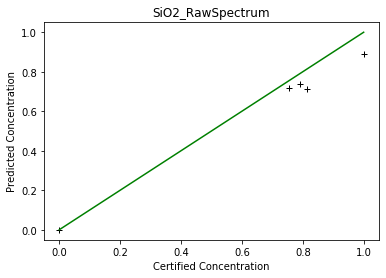

4842.800199821867
6088.80302702561
6813.67667573952
6554.280019806602
9399.956819495112
3473.626596539608
4420.458806737162
5241.2687517237055
3560.448509268329
7594.243261252264


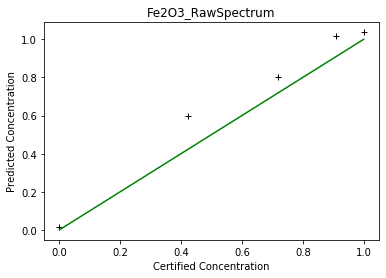

6018.784991819772
4379.754393757855
6586.808493722255
5776.794849294439
16592.44818015393
4330.031047310799
3591.5570312270283
4938.366173227335
3421.480934646272
15680.161790413898


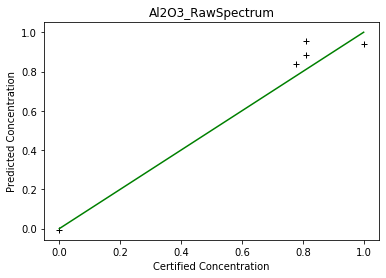

2060.553397529304
3512.55983178217
1927.4939740337338
1985.5825746807518
22640.35965075356
2291.8832404659365
2694.712442007615
2001.1268638309225
2419.956921948724
20646.679947293724


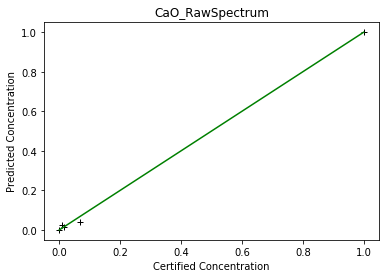

8733.227368453205
21178.312436971275
3438.8231383808893
8626.135276808654
15765.554910421037
8873.631599608367
11811.363268765823
4635.268306049473
9604.779523538058
14623.727346944283


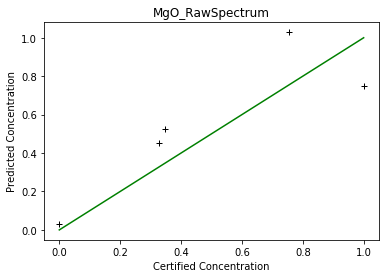

8759.670397366
3817.403240956101
7409.134799146624
6193.092120766005
2721.5622909685185
4898.735107243899
5499.916795800009
4217.083021600614
3084.0420247904667
2391.5220007962002


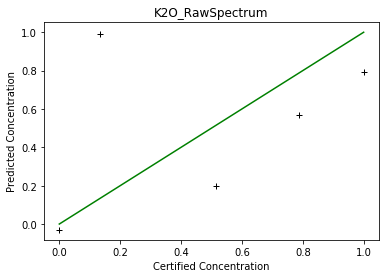

13269.201777426531
10933.819332327635
8771.79246678245
6553.688072429656
16385.145061905147
8057.742982821967
6612.09691890183
5333.578894586702
3941.7423753706194
13367.556840030567


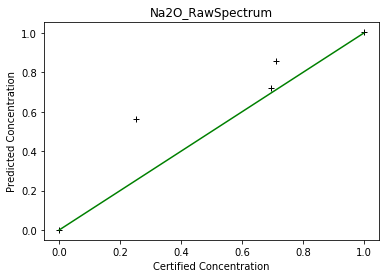

2367.9708269829293
2300.1029846296265
2286.2716554436497
3074.000044805077
2522.2857508898287
3004.826279987104
2007.614079464189
2367.8706592587946
2450.663862638462
2449.994106053352


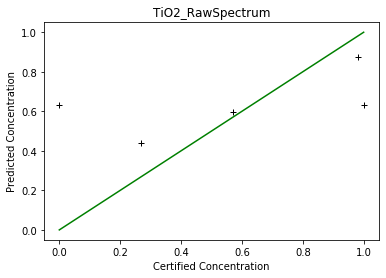

In [5]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm_notebook
from sklearn.linear_model import LinearRegression
import scipy.io as scio
from sklearn import preprocessing
from matplotlib import pyplot as plt

date = '20191226'

mat_flag = {'DenoisedSpectrum': '_d', 'SmoothedSpectrum': '_s', 'RawSpectrum': '_r'}
for choose_element in tqdm_notebook(['SiO2','Fe2O3','Al2O3','CaO','MgO','K2O','Na2O','TiO2']):
    for process in tqdm_notebook(['RawSpectrum']):
        try_num = 2
        #process = 'SmoothedSpectrum' #DenoisedSpectrum SmoothedSpectrum
        data_file_path = os.path.join(r'D:\data\china_2020\coeffs_cwt\coeffs_cut', choose_element)
        menu_guide_path = r'D:\data\Menu_Guide-quantitative.xlsx'
        save_path_file = os.path.join(r'D:\data\china_2020\result\BPNN results', date, 'linear regression')
        if not os.path.exists(save_path_file):
            os.mkdir(save_path_file)
        #process_path = ['DenoisedSpectrum', 'SmoothedSpectrum']
        choose_type = 'Soil_Type'
        file_list = 'Spectra_Name'
        sample_list = 'Spectra_Name'
        data_flag = pd.read_excel(menu_guide_path)
        file_names = np.array(data_flag[file_list])
        concentration = np.array(data_flag[choose_element])
        p = 150  #p可调
        ########################################################################################################################
        # train list
        train_position = [1, 3, 12, 13, 21]
        ########################################################################################################################
        # Input Data
        data_x = {'pellet': 0, 'rock': 0}
        data_y = {'pellet': 0, 'rock': 0}
        for state in ['pellet', 'rock']:
            X = None
            for index_i in train_position:
                temp_concentration = concentration[index_i]
                data_sum = 0
                for j in range(8):
                    file = state+'_'+file_names[index_i]+'_'+process+'_'+str(j)+'.txt'
                    read_path = os.path.join(data_file_path, file)
                    if not os.path.exists(read_path):
                        print(read_path)
                        continue
                    data_cache = np.loadtxt(read_path)
                    data_sum += np.sum(data_cache)
                data_sum = data_sum / 8
                print(data_sum)
                if X is None:
                    X = data_sum
                    y = temp_concentration
                else:
                    X = np.row_stack((X, data_sum))
                    y = np.row_stack((y, temp_concentration))
            min_max_scaler1 = preprocessing.MinMaxScaler()
            data_x[state] = min_max_scaler1.fit_transform(X)
            min_max_scaler2 = preprocessing.MinMaxScaler()
            data_y[state] = min_max_scaler2.fit_transform(y)
            
        reg = LinearRegression()
        reg.fit(data_x['pellet'], data_y['pellet'])
        r2_tr = reg.score(data_x['pellet'], data_y['pellet'])
        p1 = reg.coef_
        p2 = reg.intercept_
        y_pred = reg.predict(data_x['rock'])
        scio.savemat(os.path.join(save_path_file, 'wavelet_'+choose_element+'_'+process+'_cwt_reg.mat'), {'pred_'+choose_element+mat_flag[process]+'_cwt_reg': y_pred})
        plt.plot(data_y['rock'].reshape(-1), y_pred.reshape(-1), 'k+')
        plt.plot([0, 1], [0, 1], 'g-')
        plt.xlabel('Certified Concentration')
        plt.ylabel('Predicted Concentration')
        plt.title(choose_element + '_' + process)
        plt.show()

In [47]:
print(data_x['pellet'])
print(data_y['pellet'])

[[0.        ]
 [0.61203795]
 [0.23794782]
 [0.083091  ]
 [1.        ]]
[[0.97997156]
 [0.2696284 ]
 [0.57010782]
 [1.        ]
 [0.        ]]


In [62]:
data_raw = np.loadtxt(r'D:\data\china_2020\result\K2O\skb_scores\pellet_RawSpectrum.txt')
data_denoised = np.loadtxt(r'D:\data\china_2020\result\K2O\skb_scores\pellet_DenoisedSpectrum.txt')

In [63]:
print(np.max(data_raw, axis=0))
print(np.max(data_denoised, axis=0))
j=0
for i in range(data_raw.shape[0]):
    if data_raw[i] > 3500:
        j += 1
print(j)
j=0
for i in range(data_denoised.shape[0]):
    if data_denoised[i] > 3500:
        j += 1
print(j)
j=0

2713.878857743189
2841.0983590603787
0
0


In [59]:
data_raw

array([115.98587212, 118.80701316, 115.62658366, ...,  87.81728485,
        99.48014318, 100.40413441])